# KLF beamline simulation results, take 8 (cylindrical beam pipe shielding)
This is an eighth simulation of the KLF beam in Hall D, with the same statistics as the first. The only change from take 7 is that an iron tube was wrapped around the beam pipe starting 2m downstream from the pair spectrometer and ending 3m upstream of the entrance to the GlueX detector, approximately 5m in length. The shielding tube fits tightly around the existing beam pipe (outer radius 3.6cm) and has an outer radius of 8.5cm. Everything else about the simulation is unchanged from take 7.

Plot summed results from a simulation of 5G simulated beam photons in the range [2,12] GeV from the CPS incident on the beryllium conversion target in the Hall D alcove. This simulation subtends approximately 1.2 milliseconds of beam at 5uA electron beam intensity at 12GeV. Meson production in the target is using the standard G4 physics lists in use by hdgeant4, augmented by diffractive phi(1020)->KL,KS production. The phi(1020) center of mass decay angular distribution is assumed uniform, whereas the true distribution should be closer to sin^2(theta_GJ), but this should not impact the result appreciably because of the small momentum of the neutron kaons in the phi rest frame. The simulated flux is somewhat lower than the true one because of the following features that are missing from this simulation.
1. charged K+,K- decays of the phi are not simulated, but these could contribute to the final klong flux due to charge-exchange elastic scattering in the target or tungesten plug downstream of the conversion point
2. additional contributions from non-diffractive reactions with hidden strangeness: f0(980), f2(1270), f2(1525), f0(1500), f0(1710), phi(1680), phi3(1850)

In [1]:
import ROOT
#%jsroot on
import os
os.chdir("/srv/jupyter/hdgeant4 studies")
import pyxrootd.client as xclient
import numpy as np
#%pip install --user gluex.jupyroot
from gluex.jupyroot.treeview import treeview

In [2]:
import dask.distributed
import dask
dclient = dask.distributed.Client(n_workers=50, threads_per_worker=1, dashboard_address='0.0.0.0:8790')

In [3]:
mass_proton = 0.93827208943 # GeV/c^2
mass_neutron = 0.93956542194 # GeV/c^2
mass_klong = 0.497611 # GeV/c^2
mass_muon = 0.10566 # GeV/c^2
mass_electron = 5.11e-3
mass_deuteron = mass_proton + mass_neutron - 2.2e-3 # GeV/c^2

In [4]:
xrdurl = "root://cn445.storrs.hpc.uconn.edu"
xrdpath = "/Gluex/resilient/simulation/KLFbeam-8-2024/"
rfile1 = ROOT.TFile.Open(xrdurl + xrdpath + "bgprofiles8_1.root")
chains = {}
for tree in rfile1.GetListOfKeys():
    chains[tree.GetName()] = ROOT.TChain(tree.GetName(), tree.GetTitle())
    print("created new chain for", tree.GetName())

created new chain for det1
created new chain for det1
created new chain for det3
created new chain for det5


In [5]:
xfs = xclient.FileSystem(xrdurl)
for f in xfs.dirlist(xrdpath)[1]['dirlist']:
    if "bgprofiles8_" in f['name']:
        for chain in chains:
            chains[chain].Add(xrdurl + xrdpath + f['name'])
for chain in chains.values():
    print("chain", chain.GetName(), "created with", chain.GetNtrees(), "files")

chain det1 created with 9999 files
chain det3 created with 9999 files
chain det5 created with 9999 files


In [6]:
tview = treeview(chains['det5'], "Klong_beam8.root/det5")
tview.enable_dask_cluster(dclient)

## Particles at the entrance to the GlueX liquid hydrogen target

In [7]:
def det5_ptype_hinit():
    h = {}
    h['hptypef'] = ROOT.TH1D('hptypef', "particle type at GlueX entrance plane", 100, 0, 100)
    h['hptypef'].GetXaxis().SetTitle("Geant particle type")
    h['hptypef'].GetYaxis().SetTitle("counts")
    return h

def det5_ptype_hfill(row, histos):
    if row.x[5] > 0:
        histos['hptypef'].Fill(row.ptype)
    return histos

n = tview.declare_histograms("particle type", det5_ptype_hinit, det5_ptype_hfill)

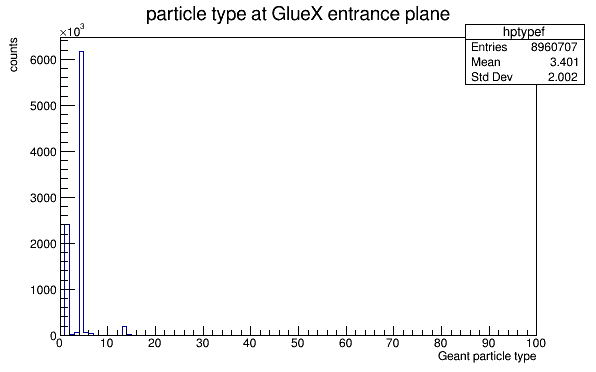

In [8]:
#tview.fill_histograms()
n = tview.draw('hptypef', width=600)

In [9]:
def det5_klong_hinit():
    h = {}
    h['hklfspot'] = ROOT.TH2D("hklfspot", "klong impact point at GlueX entrance plane", 600, -300, 300, 600, -300, 300)
    h['hklfspot'].GetXaxis().SetTitle("impact x (cm)")
    h['hklfspot'].GetYaxis().SetTitle("impact y (cm)")
    h['hklfspot2'] = ROOT.TH2D("hklfspot2", "klong impact point at GlueX entrance plane", 100, -10, 10, 100, -10, 10)
    h['hklfspot2'].GetXaxis().SetTitle("impact x (cm)")
    h['hklfspot2'].GetYaxis().SetTitle("impact y (cm)")
    h['hklftotE'] = ROOT.TH1D('hklftotE', "klong total energy inside pipe at GlueX entrance plane", 120, 0, 12)
    h['hklftotE'].GetXaxis().SetTitle("klong total energy (GeV)")
    h['hklftotE'].GetYaxis().SetTitle("counts")
    h['hklfmom'] = ROOT.TH1D('hklfmom', "klong momentum inside pipe at GlueX entrance plane", 120, 0, 12)
    h['hklfmom'].GetXaxis().SetTitle("klong momentum (GeV/c)")
    h['hklfmom'].GetYaxis().SetTitle("counts")
    return h

def det5_klong_hfill(row, histos):
    if row.ptype == 10 and row.x[5] > 0:
        histos['hklfspot'].Fill(row.x[0], row.x[1])
        histos['hklfspot2'].Fill(row.x[0], row.x[1])
        if row.x[0]**2 + row.x[1]**2 < 9:
            histos['hklftotE'].Fill(row.totE)
            histos['hklfmom'].Fill((row.totE**2 - mass_klong**2)**0.5)
    return histos

n = tview.declare_histograms("forward klong at det5", det5_klong_hinit, det5_klong_hfill)

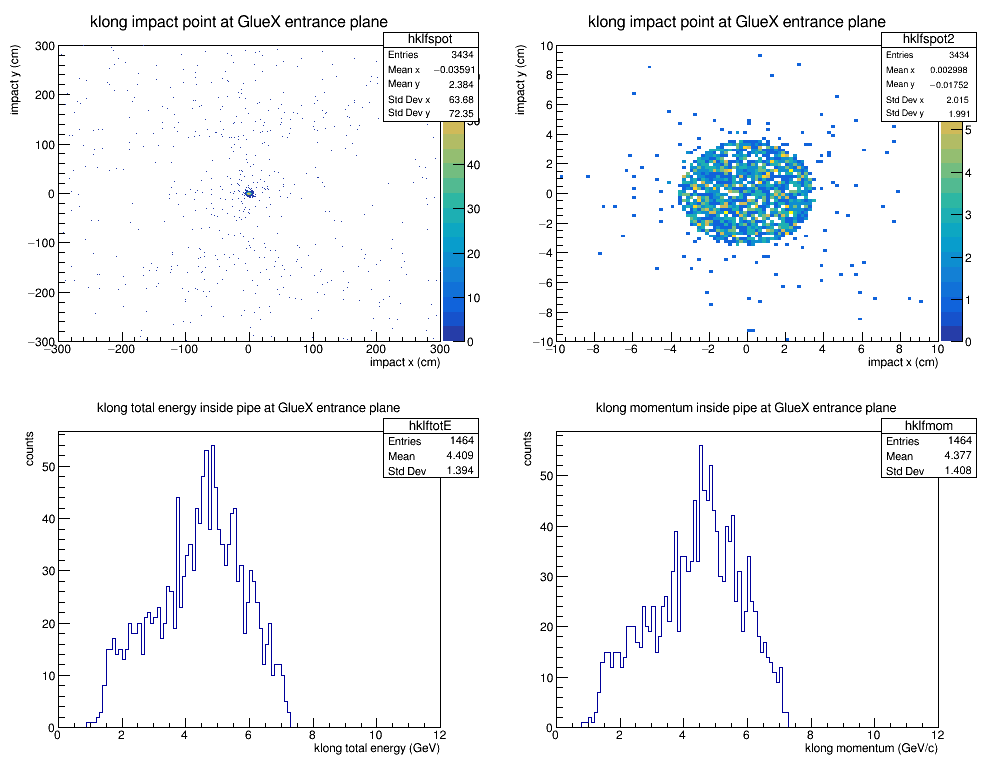

In [10]:
#tview.fill_histograms()
n = tview.draw([['hklfspot', 'hklfspot2'], ['hklftotE', 'hklfmom']],
               [['colz', 'colz'], ['', '']])

In [11]:
def det5_gamma_hinit():
    h = {}
    h['hgamfspot'] = ROOT.TH2D('hgamfspot', "gamma impact point at GlueX entrance plane", 600, -300, 300, 600, -300, 300)
    h['hgamfspot'].GetXaxis().SetTitle("impact x (cm)")
    h['hgamfspot'].GetYaxis().SetTitle("impact y (cm)")
    h['hgamfspot2'] = ROOT.TH2D('hgamfspot2', "gamma impact point at GlueX entrance plane", 200, -10, 10, 200, -10, 10)
    h['hgamfspot2'].GetXaxis().SetTitle("impact x (cm)")
    h['hgamfspot2'].GetYaxis().SetTitle("impact y (cm)")
    h['hgamftotE'] = ROOT.TH1D('hgamftotE', "gamma total energy inside pipe at GlueX entrance plane", 500, -5, 1)
    h['hgamftotE'].GetXaxis().SetTitle("log10(gamma energy / GeV)")
    h['hgamftotE'].GetYaxis().SetTitle("counts")
    for i in range(4):
        h[f'hgamftotE{i}'] = ROOT.TH1D(f'hgamftotE{i}', "gamma total energy inside pipe at GlueX entrance plane", 500, -5, 1)
        h[f'hgamftotE{i}'].GetXaxis().SetTitle("log10(gamma energy / GeV)")
        h[f'hgamftotE{i}'].GetYaxis().SetTitle("counts")
    return h

def det5_gamma_hfill(row, histos):
    if row.ptype == 1 and row.x[5] > 0:
        histos['hgamfspot'].Fill(row.x[0], row.x[1])
        histos['hgamfspot2'].Fill(row.x[0], row.x[1])
        if row.x[0]**2 + row.x[1]**2 < 9:
            histos['hgamftotE'].Fill(np.log10(row.totE))
            if row.run <= 122500:
                histos['hgamftotE0'].Fill(np.log10(row.totE))
            elif row.run <= 125000:
                histos['hgamftotE1'].Fill(np.log10(row.totE))
            elif row.run <= 127500:
                histos['hgamftotE2'].Fill(np.log10(row.totE))
            else:
                histos['hgamftotE3'].Fill(np.log10(row.totE))
    return histos

n = tview.declare_histograms("forward gamma at det5", det5_gamma_hinit, det5_gamma_hfill)

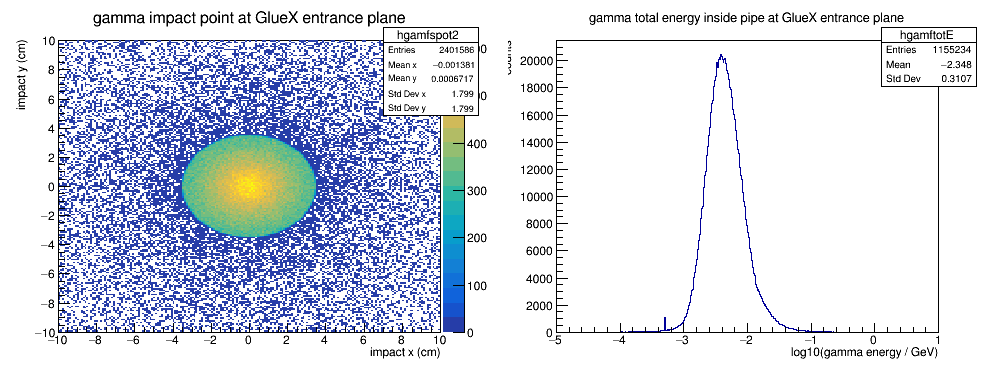

In [12]:
#tview.fill_histograms()
n = tview.draw(['hgamfspot2', 'hgamftotE'], ['colz', ''])

In [13]:
def det5_neutron_hinit():
    h = {}
    h['hneufspot'] = ROOT.TH2D('hneufspot', "neutron impact point at GlueX entrance plane", 600, -300, 300, 600, -300, 300)
    h['hneufspot'].GetXaxis().SetTitle("impact x (cm)")
    h['hneufspot'].GetYaxis().SetTitle("impact y (cm)")
    h['hneufspot2'] = ROOT.TH2D('hneufspot2', "neutron impact point at GlueX entrance plane", 100, -10, 10, 100, -10, 10)
    h['hneufspot2'].GetXaxis().SetTitle("impact x (cm)")
    h['hneufspot2'].GetYaxis().SetTitle("impact y (cm)")
    h['hneufkinE'] = ROOT.TH1D('hneufkinE', "neutron kinetic energy inside pipe at GlueX entrance plane", 500, -5, 1)
    h['hneufkinE'].GetXaxis().SetTitle("log10(neutron kinetic energy / GeV)")
    h['hneufkinE'].GetYaxis().SetTitle("counts")
    return h

def det5_neutron_hfill(row, histos):
    if row.ptype==13 and row.x[5] > 0:
        histos['hneufspot'].Fill(row.x[0], row.x[1])
        histos['hneufspot2'].Fill(row.x[0], row.x[1])
        if row.x[0]**2 + row.x[1]**2 < 9:
            histos['hneufkinE'].Fill(np.log10(row.totE - mass_neutron)) 

n = tview.declare_histograms("forward neutrons at det5", det5_neutron_hinit, det5_neutron_hfill)

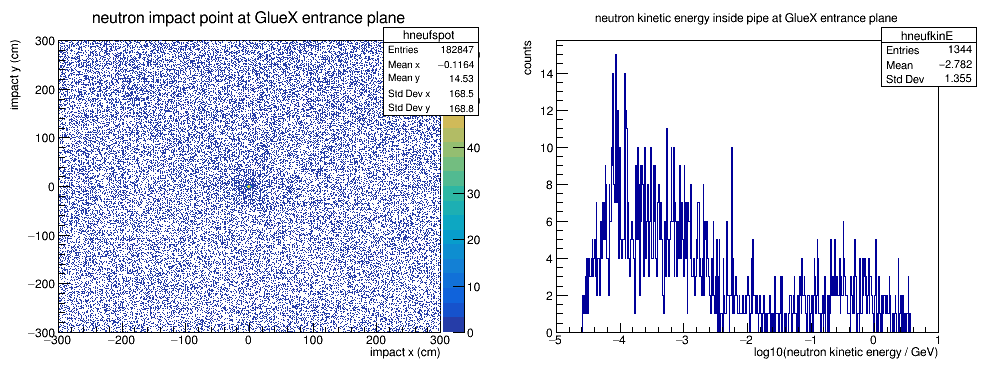

In [14]:
#tview.fill_histograms()
n = tview.draw(['hneufspot', 'hneufkinE'], ['colz', ''])

In [15]:
hneufkinE = tview.get('hneufkinE')
print(hneufkinE.Integral(hneufkinE.GetXaxis().FindBin(-1), 500))

225.0


In [16]:
def det5_proton_hinit():
    h = {}
    h['hprofspot'] = ROOT.TH2D('hprofspot', "proton impact point at GlueX entrance plane", 600, -300, 300, 600, -300, 300)
    h['hprofspot'].GetXaxis().SetTitle("impact x (cm)")
    h['hprofspot'].GetYaxis().SetTitle("impact y (cm)")
    h['hprofkinE'] = ROOT.TH1D('hprofkinE', "proton kinetic energy inside pipe at GlueX entrance plane", 500, -5, 1)
    h['hprofkinE'].GetXaxis().SetTitle("log10(proton kinetic energy / GeV)")
    h['hprofkinE'].GetYaxis().SetTitle("counts")
    return h

def det5_proton_hfill(row, histos):
    if row.ptype == 14 and row.x[5] > 0:
        histos['hprofspot'].Fill(row.x[0], row.x[1])
        if row.x[0]**2 + row.x[1]**2 < 9:
            histos['hprofkinE'].Fill(np.log10(row.totE - mass_proton))
    return histos

n = tview.declare_histograms("forward protons at det5", det5_proton_hinit, det5_proton_hfill)

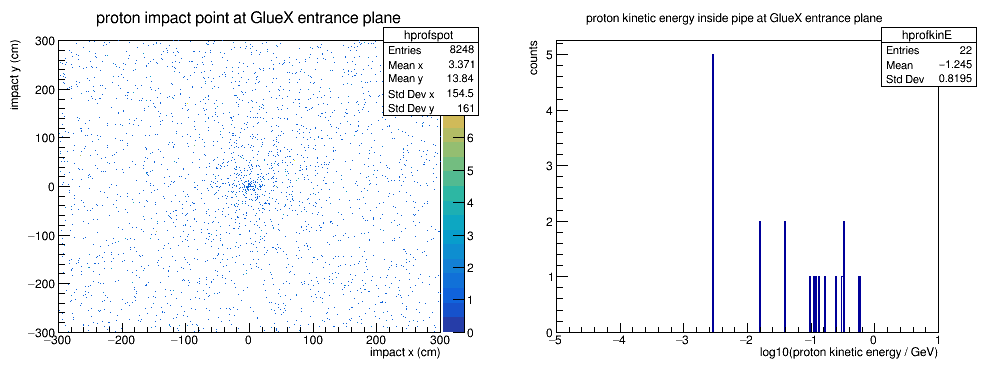

In [17]:
#tview.fill_histograms()
n = tview.draw(['hprofspot', 'hprofkinE'], ['colz', ''])

In [18]:
def det5_nuclei_hinit():
    h = {}
    h['hdeufspot'] = ROOT.TH2D('hdeufspot', "deuteron impact point at GlueX entrance plane", 600, -300, 300, 600, -300, 300)
    h['hdeufspot'].GetXaxis().SetTitle("impact x (cm)")
    h['hdeufspot'].GetYaxis().SetTitle("impact y (cm)")
    h['hdeufkinE'] = ROOT.TH1D('hdeufkinE', "deuteron kinetic energy inside pipe at GlueX entrance plane", 500, -5, 1)
    h['hdeufkinE'].GetXaxis().SetTitle("log10(deuteron kinetic energy / GeV)")
    h['hdeufkinE'].GetYaxis().SetTitle("counts")
    return h

def det5_nuclei_hfill(row, histos):
    if row.ptype == 45 and row.x[5] > 0:
        histos['hdeufspot'].Fill(row.x[0], row.x[1])
        if row.x[0]**2 + row.x[1]**2 < 9:
            histos['hdeufkinE'].Fill(np.log10(row.totE - mass_deuteron))
    return histos

n = tview.declare_histograms("forward nuclei at det5", det5_nuclei_hinit, det5_nuclei_hfill)

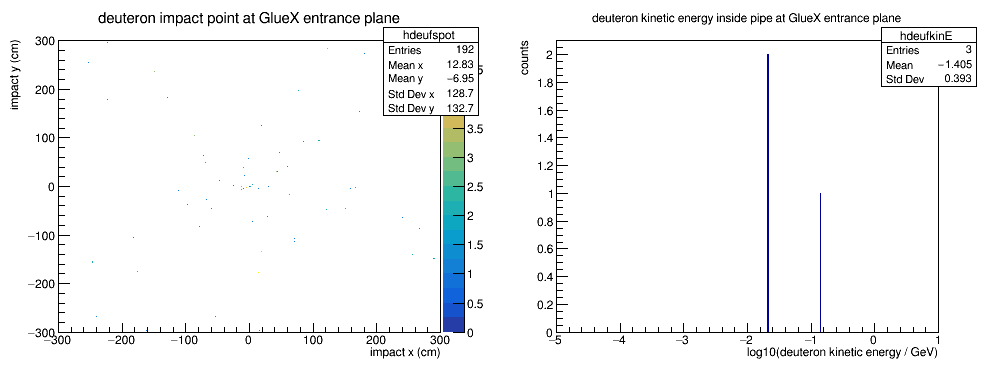

In [19]:
#tview.fill_histograms()
n = tview.draw(['hdeufspot', 'hdeufkinE'], ['colz', ''])

In [20]:
def det5_muons_hinit():
    h = {}
    h['hmufspot'] = ROOT.TH2D('hmufspot', "muon impact point at GlueX entrance plane", 600, -300, 300, 600, -300, 300)
    h['hmufspot'].GetXaxis().SetTitle("impact x (cm)")
    h['hmufspot'].GetYaxis().SetTitle("impact y (cm)")
    h['hmufkinE'] = ROOT.TH1D('hmufkinE', "muon kinetic energy inside pipe at GlueX entrance plane", 500, -5, 1)
    h['hmufkinE'].GetXaxis().SetTitle("log10(muon kinetic energy / GeV)")
    h['hmufkinE'].GetYaxis().SetTitle("counts")
    return h

def det5_muons_hfill(row, histos):
    if (row.ptype == 5 or row.ptype == 6) and row.x[5] > 0:
        histos['hmufspot'].Fill(row.x[0], row.x[1])
        if row.x[0]**2 + row.x[1]**2 < 9:
            histos['hmufkinE'].Fill(np.log10(row.totE - mass_muon))
    return histos

n = tview.declare_histograms("forward muons at det5", det5_muons_hinit, det5_muons_hfill)

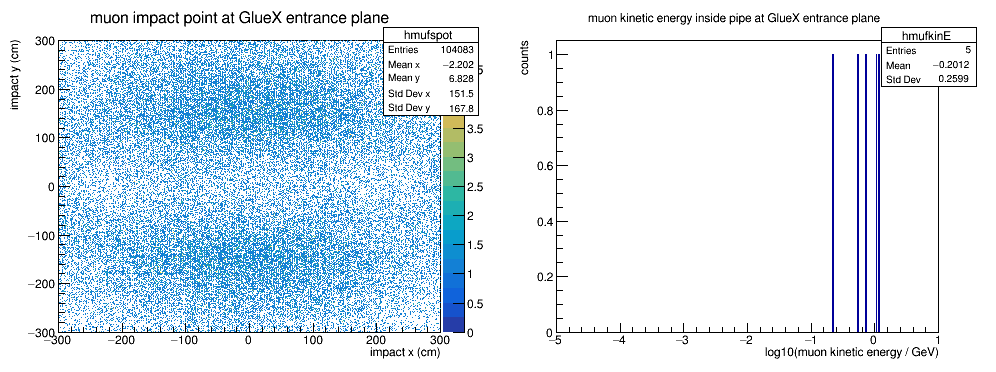

In [21]:
#tview.fill_histograms()
n = tview.draw(['hmufspot', 'hmufkinE'], ['colz', ''])

In [22]:
def det5_electron_hinit():
    h = {}
    h['helefspot'] = ROOT.TH2D('helefspot', "e+/e- impact point at GlueX entrance plane", 600, -300, 300, 600, -300, 300)
    h['helefspot'].GetXaxis().SetTitle("impact x (cm)")
    h['helefspot'].GetYaxis().SetTitle("impact y (cm)")
    h['helefkinE'] = ROOT.TH1D('helefkinE', "e+/e- kinetic energy inside pipe at GlueX entrance plane", 500, -5, 1)
    h['helefkinE'].GetXaxis().SetTitle("log10(electron kinetic energy / GeV)")
    h['helefkinE'].GetYaxis().SetTitle("counts")
    return h

def det5_electron_hfill(row, histos):
    if (row.ptype == 2 or row.ptype == 3) and row.x[5] > 0:
        histos['helefspot'].Fill(row.x[0], row.x[1])
        if row.x[0]**2 + row.x[1]**2 < 9:
            histos['helefkinE'].Fill(np.log10(row.totE - mass_electron))
    return histos

n = tview.declare_histograms("forward electrons at det5", det5_electron_hinit, det5_electron_hfill)

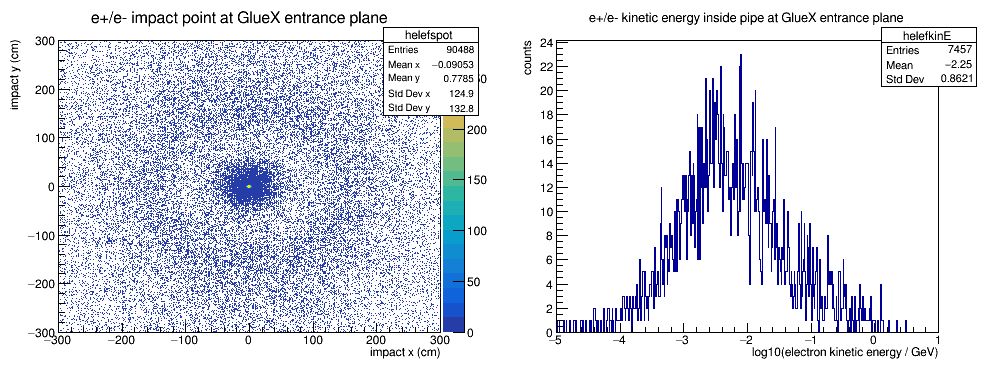

In [23]:
#tview.fill_histograms()
n = tview.draw(['helefspot', 'helefkinE'], ['colz', ''])

In [24]:
h = tview.get('helefkinE')
h.Integral(h.GetXaxis().FindBin(np.log10(0.5)), 500)

46.0

## Klong production vertex for events with klong at the GlueX H2 target 
The contents of the bgprofiles det5 tree are as follows.

    ******************************************************************************
    *Tree    :det5      : hits in virtual detector 5                             *
    *Entries :     1666 : Total =          272447 bytes  File  Size =     164616 *
    *        :          : Tree compression factor =   1.64                       *
    ******************************************************************************
    *Br    0 :totE      : totE/F                                                 *
    *Entries :     1666 : Total  Size=       7216 bytes  File Size  =       6041 *
    *Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.11     *
    *............................................................................*
    *Br    1 :time      : time/F                                                 *
    *Entries :     1666 : Total  Size=       7216 bytes  File Size  =       5439 *
    *Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.24     *
    *............................................................................*
    *Br    2 :x         : x[7]/F                                                 *
    *Entries :     1666 : Total  Size=      47259 bytes  File Size  =      40359 *
    *Baskets :        2 : Basket Size=      32000 bytes  Compression=   1.16     *
    *............................................................................*
    *Br    3 :ppol      : ppol/F                                                 *
    *Entries :     1666 : Total  Size=       7216 bytes  File Size  =        403 *
    *Baskets :        1 : Basket Size=      32000 bytes  Compression=  16.71     *
    *............................................................................*
    *Br    4 :xspot     : xspot[2]/F                                             *
    *Entries :     1666 : Total  Size=      13891 bytes  File Size  =      10431 *
    *Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.28     *
    *............................................................................*
    *Br    5 :ptype     : ptype/I                                                *
    *Entries :     1666 : Total  Size=       7221 bytes  File Size  =        749 *
    *Baskets :        1 : Basket Size=      32000 bytes  Compression=   8.99     *
    *............................................................................*
    *Br    6 :det       : det/I                                                  *
    *Entries :     1666 : Total  Size=       7211 bytes  File Size  =        139 *
    *Baskets :        1 : Basket Size=      32000 bytes  Compression=  48.45     *
    *............................................................................*
    *Br    7 :mint      : mint/I                                                 *
    *Entries :     1666 : Total  Size=       7216 bytes  File Size  =        140 *
    *Baskets :        1 : Basket Size=      32000 bytes  Compression=  48.11     *
    *............................................................................*
    *Br    8 :xint      : xint[mint][3]/F                                        *
    *Entries :     1666 : Total  Size=     167648 bytes  File Size  =      99714 *
    *Baskets :        6 : Basket Size=      32000 bytes  Compression=   1.68     *
    *............................................................................*

In [25]:
alcove_entry_wall_z = -2454.5
beconv_target_start_z = 125.6 + alcove_entry_wall_z
tungsten_plug_start_z = 166.1 + alcove_entry_wall_z
vacuum_window_z = 259.3 + alcove_entry_wall_z
inches = 2.54 # cm
pipe_radius = 1.935 * inches/2
eltu_xradius = 4.95
eltu_yradius = 2.29

In [26]:
def det5_klong_interactions_hinit():
    h = {}
    h['hklmint'] = ROOT.TH1D('hklmint', "interaction multiplicity of klongs at GlueX target", 100, 0, 100)
    h['hklmint'].GetXaxis().SetTitle("interaction multiplicity")
    h['hklmint'].GetYaxis().SetTitle("counts")
    for i in range(8):
        hname = f"hklzint{i+1}"
        h[hname] = ROOT.TH1D(hname, f"z of interaction {i+1} leading to klongs at GlueX target", 2500, -2500, 0)
        h[hname].GetXaxis().SetTitle("interaction vertex z (cm)")
        h[hname].GetYaxis().SetTitle("counts")
        hname2 = f"hklxyint{i+1}"
        h[hname2] = ROOT.TH2D(hname2, f"y vs x of interaction {i+1} leading to klongs at GlueX target", 100, -5, 5, 100, -5, 5)
        h[hname2].GetXaxis().SetTitle("interaction x (cm)")
        h[hname2].GetYaxis().SetTitle("interaction y (cm)")
        hname3 = f"hklzvint{i+1}"
        h[hname3] = ROOT.TH1D(hname3, f"z of interaction {i+1} in vacuum leading to klongs at GlueX target", 2500, -2500, 0)
        h[hname3].GetXaxis().SetTitle("interaction vertex z (cm)")
        h[hname3].GetYaxis().SetTitle("counts")
    return h

def det5_klong_interactions_hfill(row, histos):
    if row.ptype == 10 and row.x[0]**2 + row.x[1]**2 < 9 and row.x[5] > 0:
        histos['hklmint'].Fill(row.mint)
        for i in range(8):
            histos[f'hklzint{i+1}'].Fill(row.xint[i*3+2])
            if row.xint[i*3+2] > vacuum_window_z + 1:
                histos[f'hklxyint{i+1}'].Fill(row.xint[i*3+0], row.xint[i*3+1])
                if row.xint[i*3+0]**2 + row.xint[i*3+1]**2 < pipe_radius**2:
                    histos[f'hklzvint{i+1}'].Fill(row.xint[i*3+2])
    return histos

n = tview.declare_histograms("klong interactions", det5_klong_interactions_hinit, det5_klong_interactions_hfill)

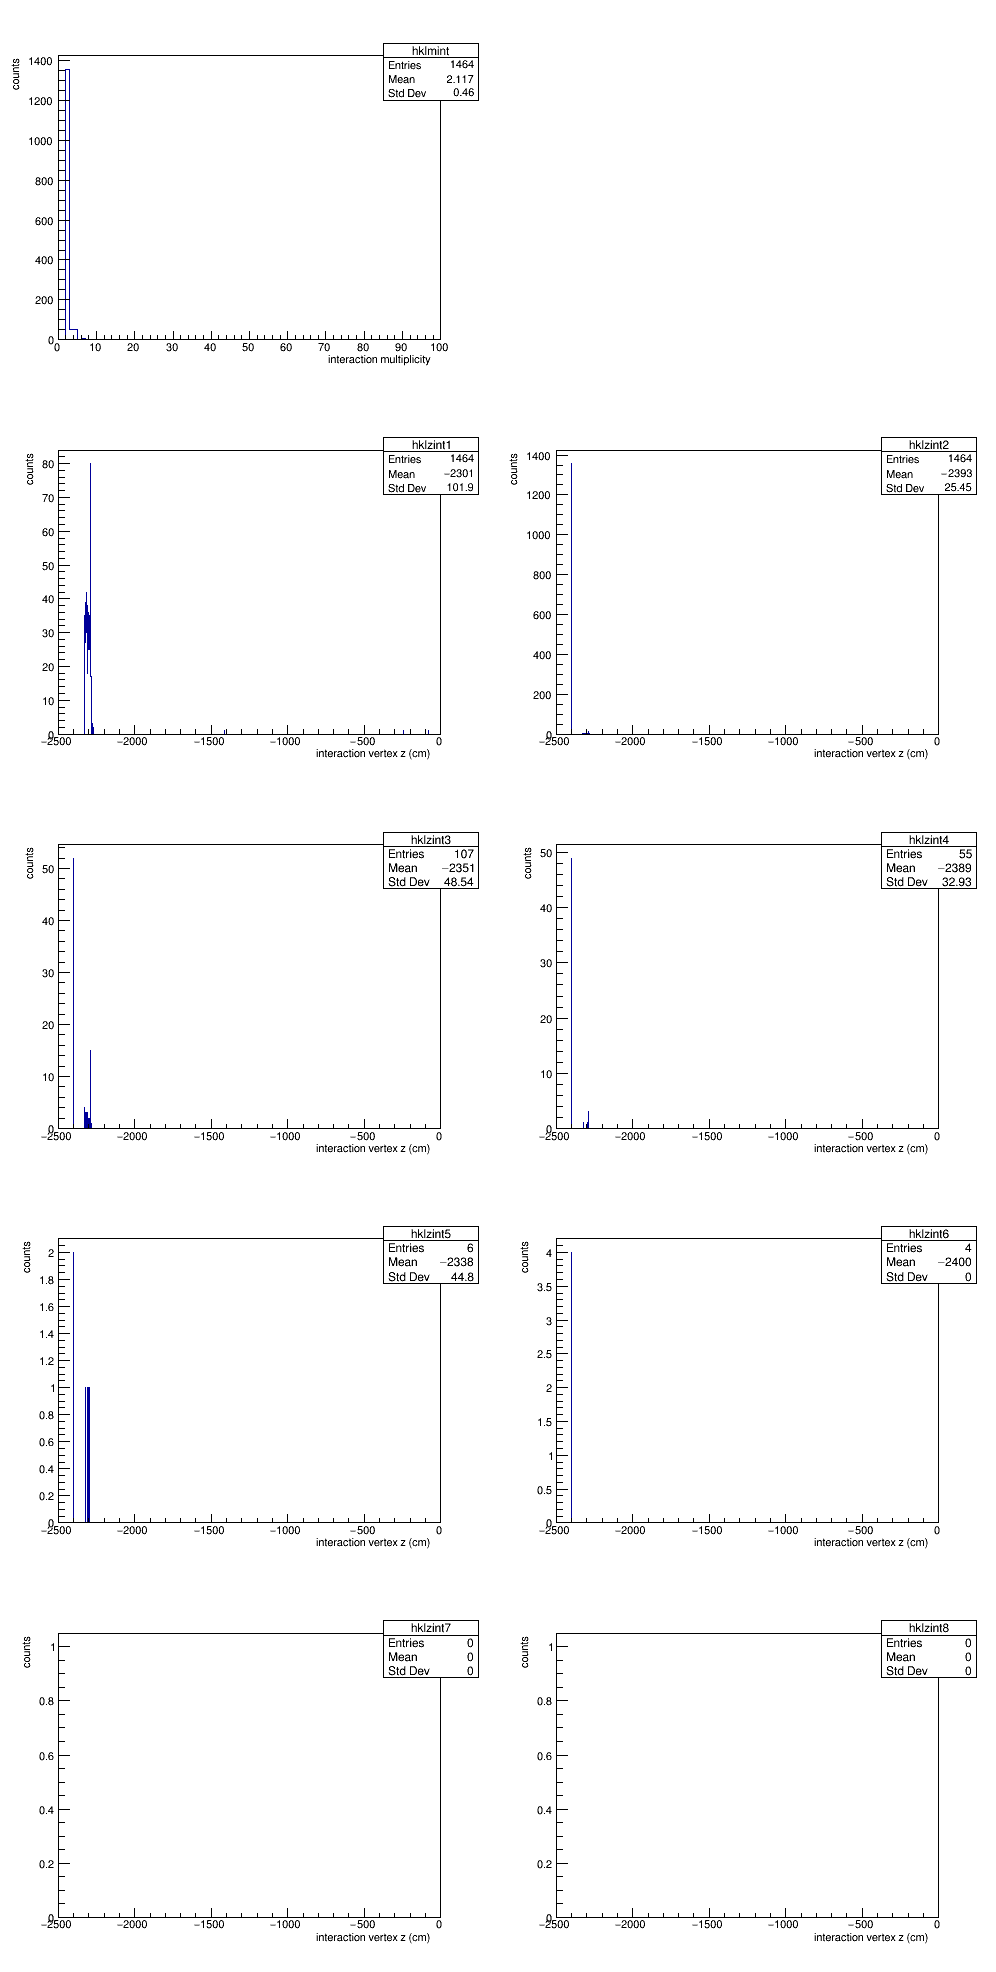

In [27]:
#tview.fill_histograms(chunksize=10)
n = tview.draw([['hklmint', ]] + [[f'hklzint{i}', f'hklzint{i+1}'] for i in range(1,8,2)],
               [['', ''] for i in range(0,9,2)])

In [28]:
print("Beryllium converter starts at", beconv_target_start_z, "cm")
print("Tungsten plug starts at", tungsten_plug_start_z, "cm")
print("vacuum starts at", vacuum_window_z, "cm")

Beryllium converter starts at -2328.9 cm
Tungsten plug starts at -2288.4 cm
vacuum starts at -2195.2 cm


## what is causing these klong production vertices past the vacuum window?

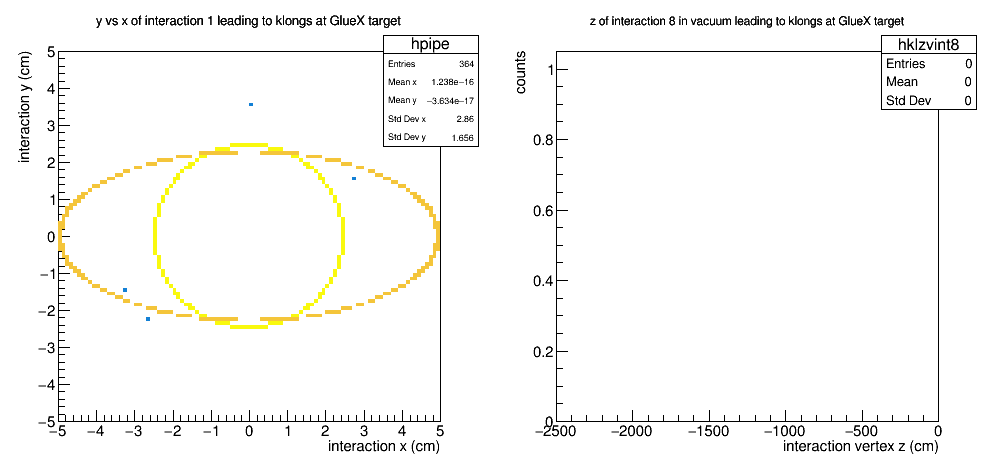

In [29]:
hklxyint1 = tview.get('hklxyint1')
hpipe = hklxyint1.Clone('hpipe')
heltu = hklxyint1.Clone('heltu')
[h.Reset() for h in (hpipe, heltu)]
for ix in range(hpipe.GetNbinsX()):
    for iy in range(hpipe.GetNbinsY()):
        r2 = hpipe.GetXaxis().GetBinCenter(ix+1)**2 + hpipe.GetYaxis().GetBinCenter(iy+1)**2
        rho2 = ((hpipe.GetXaxis().GetBinCenter(ix+1) / eltu_xradius)**2 + 
                (hpipe.GetYaxis().GetBinCenter(iy+1) / eltu_yradius)**2)
        if abs(r2**0.5 - pipe_radius) < hpipe.GetXaxis().GetBinWidth(1)/2:
            hpipe.SetBinContent(ix+1, iy+1, 5)
        if abs(rho2 - 1) < 0.03:
            hpipe.SetBinContent(ix+1, iy+1, 4)
[tview.put(h) for h in (hpipe, heltu)]
n = tview.draw([[['hpipe', 'heltu'] + [f'hklxyint{8-i}' for i in range(8)] + ['hpipe', 'heltu'],
                 [f'hklzvint{8-i}' for i in range(8)]]],
               [[['col', 'same'*11], ['', 'same'*7]]], 
               width=500, height=500, titles=0, stats=0)

## Look at the time structure of the photon beam

In [30]:
def det5_timing_hinit():
    h = {}
    h['htimeklong'] = ROOT.TH1D('htimeklong', "time of klongs at GlueX entrance plane", 11000, -20, 200)
    h['htimeklong'].GetXaxis().SetTitle("time (ns)")
    h['htimeklong'].GetYaxis().SetTitle("counts")
    h['htimegamma'] = ROOT.TH1D('htimegamma', "time of gammas at GlueX entrance plane", 11000, -20, 200)
    h['htimegamma'].GetXaxis().SetTitle("time (ns)")
    h['htimegamma'].GetYaxis().SetTitle("counts")
    h['htimeneutron'] = ROOT.TH1D('htimeneutron', "time of neutrons at GlueX entrance plane", 11000, -20, 200)
    h['htimeneutron'].GetXaxis().SetTitle("time (ns)")
    h['htimeneutron'].GetYaxis().SetTitle("counts")
    h['htimemuon'] = ROOT.TH1D('htimemuon', "time of muons at GlueX entrance plane", 11000, -20, 200)
    h['htimemuon'].GetXaxis().SetTitle("time (ns)")
    h['htimemuon'].GetYaxis().SetTitle("counts")
    return h

def det5_timing_hfill(row, histos):
    if row.ptype == 10 and row.x[5] > 0:
        histos['htimeklong'].Fill(row.time)
    elif row.ptype == 1 and row.x[5] > 0:
        histos['htimegamma'].Fill(row.time)
    elif row.ptype == 13 and row.x[5] > 0:
        histos['htimeneutron'].Fill(row.time)
    elif (row.ptype == 5 or row.ptype == 6) and row.x[5] > 0:
        histos['htimemuon'].Fill(row.time)
    return histos

n = tview.declare_histograms("det5 timing", det5_timing_hinit, det5_timing_hfill)

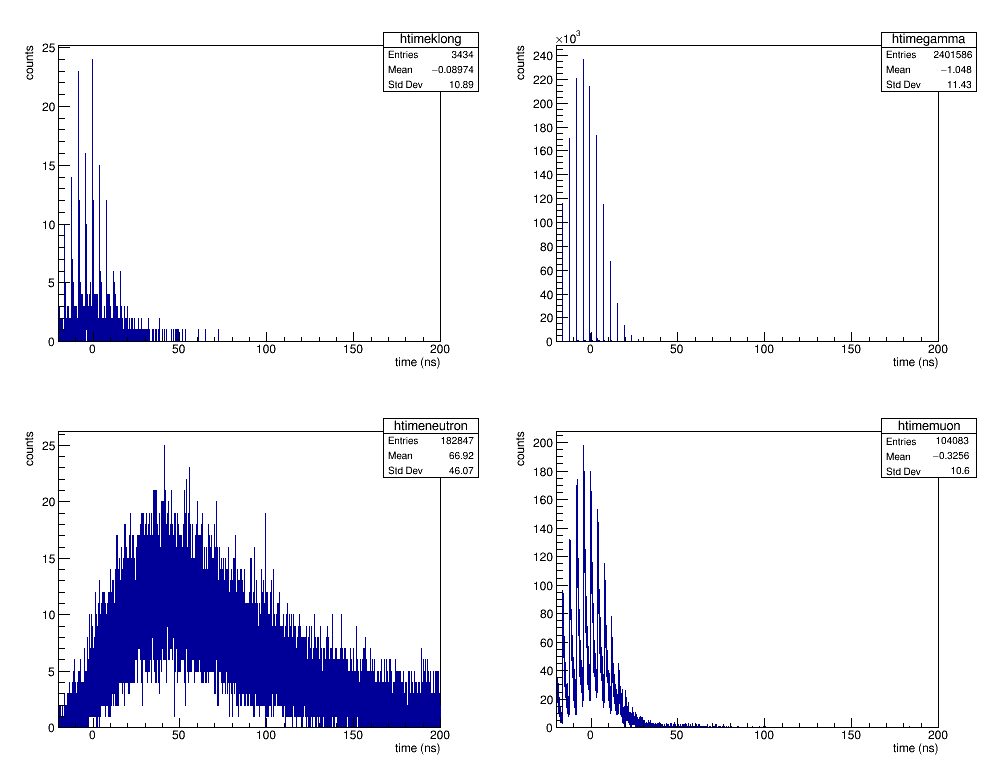

In [31]:
#tview.fill_histograms(chunksize=10)
n = tview.draw([['htimeklong', 'htimegamma'],
                ['htimeneutron', 'htimemuon']])

In [32]:
def wrap64ns(hname, htime):
    htimewrap = htime.Clone(hname)
    for i in range(htime.GetNbinsX()):
        t = htime.GetXaxis().GetBinCenter(i+1)
        for dt in [-192, -128, -64, 64, 128, 192]:
            htimewrap.Fill(t + dt, htime.GetBinContent(i+1))
    return htimewrap

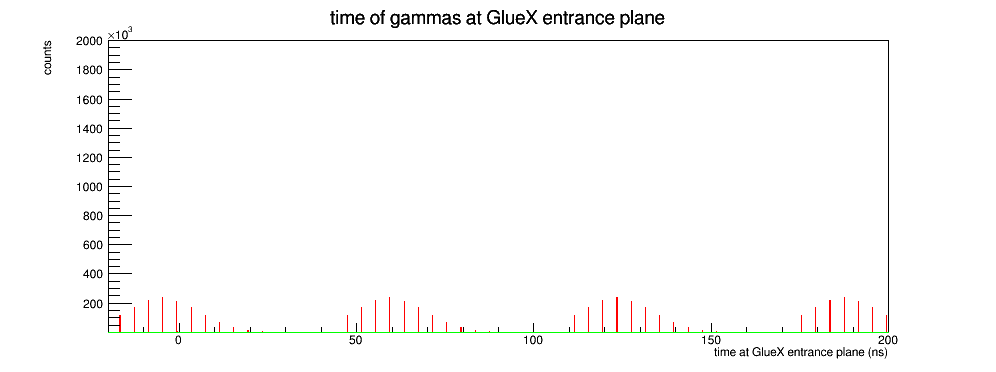

In [33]:
try:
    htgammawrap = tview.get("htgammawrap")
    htklongwrap = tview.get("htklongwrap")
    htneutwrap = tview.get("htneutwrap")
    htneutfold = tview.get("htneutfold")
    [h.SetStats(0) for h in (htgammawrap, htklongwrap, htneutwrap, htneutfold)]
    refresh = FalseX
except:
    refresh = True
    htgammawrap = wrap64ns("htgammawrap", tview.get('htimegamma'))
    htklongwrap = wrap64ns("htklongwrap", tview.get('htimeklong'))
    htneut = tview.get("htimeneutron")
    htneutfold = tview.get("htimeneutron").Clone("htneutfold")
    htneutfold.Reset()
    for i in range(htneut.GetNbinsX()):
        for n in range(int(htneut.GetBinContent(i+1))):
            t = htneut.GetXaxis().GetBinCenter(i+1) + (np.random.uniform() - 0.5) * htneut.GetXaxis().GetBinWidth(i+1)
            while t > 172:
                t -= 192
            htneutfold.Fill(t)
    htneutwrap = wrap64ns("htneutwrap", htneutfold)
    [h.SetStats(0) for h in (htgammawrap, htklongwrap, htneutwrap)]
htgammawrap.SetLineColor(2)
htneutwrap.SetLineColor(3)
htgammawrap.SetMaximum(2e6)
htgammawrap.SetMinimum(1)
htgammawrap.GetXaxis().SetTitle("time at GlueX entrance plane (ns)")
htgammawrap.GetYaxis().SetTitle("counts")
if refresh:
    [tview.put(h) for h in (htgammawrap, htklongwrap, htneutfold, htneutwrap)]
n = tview.draw([[['htgammawrap', 'htklongwrap', 'htneutwrap']]], [[['hist'*3]]], width=1000, titles=0)

In [34]:
def det5_runstats_init():
    h = {}
    h['hrunall'] = ROOT.TH1D('hrunall', "run number", 200, 120000, 130000)
    h['hrunall'].GetXaxis().SetTitle("run number")
    h['hrunall'].GetYaxis().SetTitle("events")
    h['hrunall'].SetMinimum(0.1)
    h['hrunklong'] = ROOT.TH1D('hrunklong', "run number, klongs", 200, 120000, 130000)
    h['hrunklong'].GetXaxis().SetTitle("run number")
    h['hrunklong'].GetYaxis().SetTitle("events")
    h['hrunklong'].SetLineColor(2)
    h['hrungamma'] = ROOT.TH1D('hrungamma', "run number, gammas", 200, 120000, 130000)
    h['hrungamma'].GetXaxis().SetTitle("run number")
    h['hrungamma'].GetYaxis().SetTitle("events")
    h['hrungamma'].SetLineColor(3)
    h['hrunneutron'] = ROOT.TH1D('hrunneutron', "run number, neutrons", 200, 120000, 130000)
    h['hrunneutron'].GetXaxis().SetTitle("run number")
    h['hrunneutron'].GetYaxis().SetTitle("events")
    h['hrunneutron'].SetLineColor(4)
    h['hrunmuons'] = ROOT.TH1D('hrunmuons', "run number, muons", 200, 120000, 130000)
    h['hrunmuons'].GetXaxis().SetTitle("run number")
    h['hrunmuons'].GetYaxis().SetTitle("events")
    h['hrunmuons'].SetLineColor(7)
    return h

def det5_runstats_fill(row, histos):
    if row.x[0]**2 + row.x[1]**2 < 9:
        histos['hrunall'].Fill(row.run)
        if row.ptype == 10:
            histos['hrunklong'].Fill(row.run)
        elif row.ptype == 1:
            histos['hrungamma'].Fill(row.run)
        elif row.ptype == 13:
            histos['hrunneutron'].Fill(row.run)
        elif row.ptype == 5 or row.ptype == 6:
            histos['hrunmuons'].Fill(row.run)
    return histos

n = tview.declare_histograms("det5 run statistics", det5_runstats_init, det5_runstats_fill)

fill_histograms read a total of 9998 tree files, 9143817.0 records


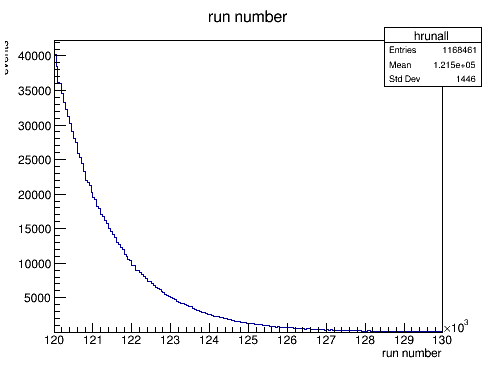

In [35]:
tview.fill_histograms(chunksize=10)
with ROOT.TFile(tview.savetorootfile, "update") as f:
    s = f.Get("det5")
    s.cd()
    hrunall = s.Get("hrunall")
    hrunall.SetMinimum(0.1)
    hrunall.Write()
n = tview.draw([[['hrunall', 'hrunklong', 'hrungamma', 'hrunneutron', 'hrunmuons']]])

In [36]:
tview.list_histograms(True)

hpipe;15        y vs x of interaction 1 leading to klongs at GlueX target        364   Mon Dec 23 11:54:30 2024
hpipe;14        y vs x of interaction 1 leading to klongs at GlueX target        364   Sun Dec 22 07:52:59 2024
hpipe;13        y vs x of interaction 1 leading to klongs at GlueX target        364   Sun Dec 22 07:52:30 2024
hpipe;12        y vs x of interaction 1 leading to klongs at GlueX target        364   Sun Dec 22 07:52:09 2024
hpipe;11        y vs x of interaction 1 leading to klongs at GlueX target        364   Sun Dec 22 07:51:36 2024
hpipe;10        y vs x of interaction 1 leading to klongs at GlueX target        364   Sun Dec 22 07:50:19 2024
hpipe;9         y vs x of interaction 1 leading to klongs at GlueX target        364   Sun Dec 22 07:49:51 2024
hpipe;8         y vs x of interaction 1 leading to klongs at GlueX target        364   Sun Dec 22 07:49:01 2024
hpipe;7         y vs x of interaction 1 leading to klongs at GlueX target        364   Sun Dec 22 07:47:

158

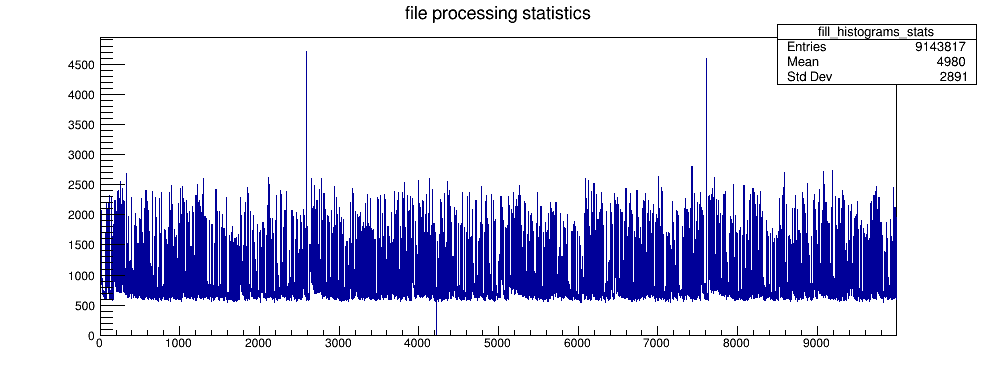

In [37]:
n = tview.draw('fill_histograms_stats', width=1000)